# Sparse Attribution Prior
This notebook demonstrates how the sparse attribution prior can build sparser models that exhibit better performance when training data is limited.

In [1]:
# Constants
RUN=54321  # Sets random seed
GRIDSIZE=131  # Fineness of hyperparameter search
n=100  # Number of models to train with best hyperparameters

In [2]:
import os, sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=str(3)

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("whitegrid",{'grid.color':'.95'})
import scipy.stats as stats
import itertools
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.metrics import r2_score, roc_auc_score, log_loss

# Import the ops object that implements sparse attribution priors
from attributionpriors.ops import AttributionPriorExplainer

/usr/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data
The data for these experiments comes from the NHANES I study, which measured a wide array of physiological data (113 variables after one-hot encoding) in 13,000 patients, as well as various outcomes 10 years later. We demonstrate the effectiveness of sparse models by testing their ability to learn from extremely limited training data -- in this case, only 100 training and 100 validation patients.

In [3]:
# Load Data
X = pd.read_csv("X_sparsity.csv")#np.random.randn(10000,10)#
y = np.load("y_sparsity.npy").astype(np.int32)#X[:,1]**2+X[:,5]>0.9#

# Train/valid/test split
Xtv,Xtest, ytv, ytest = train_test_split(X,y,random_state=200)
Xtrain, Xvalid, ytrain, yvalid = train_test_split(Xtv,ytv,random_state=100)


# Set random seed for numpy and tf
np.random.seed(RUN)
tf.set_random_seed(RUN)

# subsample train and validation data
train_inds = np.random.choice(ytrain.shape[0],100)
valid_inds = np.random.choice(yvalid.shape[0],100)
Xtrain, ytrain = Xtrain.iloc[train_inds], ytrain[train_inds]
Xvalid, yvalid = Xvalid.iloc[valid_inds], yvalid[valid_inds]

# Mean-impute, standardize, and winsorize the data
imp = Imputer()
ss = StandardScaler()
Xtrain_imp = imp.fit_transform(Xtrain)
Xvalid_imp = imp.transform(Xvalid)
Xtest_imp = imp.transform(Xtest)
Xtrain_ss = ss.fit_transform(Xtrain_imp)
Xvalid_ss = ss.transform(Xvalid_imp)
Xtest_ss = ss.transform(Xtest_imp)
Xtrain_ss = np.clip(Xtrain_ss,-3,3)
Xvalid_ss = np.clip(Xvalid_ss,-3,3)
Xtest_ss = np.clip(Xtest_ss,-3,3)

# Set aside test data
Xtest_holdout = Xtest_ss
Xtest_ss = Xvalid_ss
ytest_holdout = ytest
ytest = yvalid

# d = # features
d = X.shape[1]


/home/erion/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
# Dataset API
def make_dataset(X, Y, batch_size, shuffle=True, buffer_size=100):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    return dataset

# Set up config and session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Float64
dtype = tf.float64

# Batch size 100 (all training data), 50 references per batch
references_per_batch, dset_batch_size = 50,100
train_set = make_dataset(Xtrain_ss,np.vstack((ytrain,1-ytrain)).T.astype(np.float64),batch_size=dset_batch_size,shuffle=True,buffer_size=800)
train_set = train_set.repeat()
valid_set = make_dataset(Xvalid_ss,np.vstack((yvalid,1-yvalid)).T.astype(np.float64),batch_size=Xvalid_ss.shape[0],shuffle=True)
test_set = make_dataset(Xtest_ss,np.vstack((ytest,1-ytest)).T.astype(np.float64),batch_size=Xtest_ss.shape[0],shuffle=False)

# Train set with label all ones, for explaining risk of positive label
ones_set = make_dataset(Xtrain_ss, np.vstack((np.ones_like(ytrain),np.zeros_like(ytrain))).T.astype(np.float64), batch_size=dset_batch_size, shuffle=True, buffer_size=800)
ones_set = ones_set.repeat()

# Get dataset handle
handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(
    handle, train_set.output_types, train_set.output_shapes)
x_pl, y_true = iterator.get_next()

# Iterators
train_iter = train_set.make_initializable_iterator()
valid_iter  = valid_set.make_initializable_iterator()
test_iter  = test_set.make_initializable_iterator()
ones_iter = ones_set.make_initializable_iterator()
train_handle = sess.run(train_iter.string_handle())
valid_handle  = sess.run(valid_iter.string_handle())
test_handle  = sess.run(test_iter.string_handle())
ones_handle  = sess.run(ones_iter.string_handle())

# Reference dataset and iterators
ref_ss = Xtrain_ss#np.zeros_like(Xtrain_ss)
reference_dataset = tf.data.Dataset.from_tensor_slices((np.repeat(ref_ss,references_per_batch,axis=0)))
reference_dataset = reference_dataset.shuffle(1000)
reference_dataset = reference_dataset.batch(dset_batch_size * references_per_batch)
reference_dataset = reference_dataset.repeat()
reference_iter    = reference_dataset.make_one_shot_iterator()
background_batch = reference_iter.get_next()
background_reference_op = tf.reshape(background_batch, [-1, references_per_batch, d])

# Shorthand for useful ops
X, y, R = x_pl, y_true, background_reference_op

# Macros for indices into results tuple
PRED, EG, COST, OPT, EGOPT, EGFLAG, EXPLAINER, EGLMBD, L1LMBD, DROPLMBD = range(10)


## Models
We train 3 different types of feedforward neural networks, all with the same architecture and activations:
* `sglmodel` trains a sparse group  on the input layer of the network as in [Scardapane et al (2016)](https://arxiv.org/pdf/1607.00485.pdf).
* `l1model` trains a model with an L1 penalty on all layers.
* `egmodel` trains a model using our sparse attribution prior.

In [5]:
# Models
def sglmodel(X,R,layers=[512],eg=None,l1=None,dropout=None):
    layers = [l for l in layers]
    eg_strength = eg if eg else 0.0
    l1_strength = tf.constant(l1,dtype=tf.float64) if l1 else tf.constant(0.0,dtype=tf.float64)
    dropout_strength = dropout if dropout else 0.0
    
    explainer = AttributionPriorExplainer()
    cond_input_op, train_eg = explainer.input_to_samples_delta(X,lambda: R)
    if len(layers)>0:
        firstlayer = layers.pop(0)
        hid_layer = tf.layers.Dense(firstlayer,activation=tf.nn.relu)
        hid = hid_layer(cond_input_op)
        if dropout: hid = tf.nn.dropout(hid,keep_prob=1-dropout_strength)
        kernel = hid_layer.kernel
        for l in layers:
            hid = tf.layers.Dense(l,activation=tf.nn.relu)(hid)
            if dropout: hid = tf.nn.dropout(hid,keep_prob=1-dropout_strength)
        output = tf.layers.Dense(2)(hid)

    else:
        output_layer = tf.layers.Dense(2)
        output = output_layer(cond_input_op)
        kernel = output_layer.kernel
    
    
    y_pred = tf.nn.sigmoid(output)#model(cond_input_op)
    eg_op = explainer.shap_value_op(y_pred, cond_input_op, y[:,1])
    
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred,labels=y)
    total_cost = tf.reduce_mean(cost)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(total_cost)
    
    l1_ind = tf.reduce_sum(tf.abs(kernel)) 
    l1_group = tf.reduce_sum(tf.norm(kernel,axis=0))*tf.sqrt(tf.cast(kernel.shape[0],tf.float64))
    l1_reg = (l1_ind + l1_group)* l1_strength
        
    weighted_abs_loss = tf.reshape(tf.reduce_mean(tf.abs(tf.cast(eg_op,tf.float32)),axis=0),(1,-1))
    mad_loss = tf.abs(tf.transpose(weighted_abs_loss)-weighted_abs_loss)
    rmad_loss = tf.reduce_mean(mad_loss)/tf.reduce_mean(weighted_abs_loss)
    
    reg_lambda = tf.constant(eg_strength,dtype=tf.float32)
    reg_loss_op = -rmad_loss * reg_lambda
    reg_loss_op = reg_loss_op + tf.cast(l1_reg,dtype=tf.float32)

    train_eg_op = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(reg_loss_op)
    return (y_pred, eg_op, total_cost, optimizer, train_eg_op, train_eg, explainer, reg_lambda, l1_strength)

def l1model(X,R,layers=[512],eg=None,l1=None,dropout=None):
    layers = [l for l in layers]
    eg_strength = eg if eg else 0.0
    l1_strength = tf.constant(l1,dtype=tf.float64) if l1 else tf.constant(0.0,dtype=tf.float64)
    dropout_strength = dropout if dropout else 0.0
    
    explainer = AttributionPriorExplainer()
    cond_input_op, train_eg = explainer.input_to_samples_delta(X,lambda: R)
    
    kernels = []
    if len(layers)>0:
        firstlayer = layers.pop(0)
        hid_layer = tf.layers.Dense(firstlayer,activation=tf.nn.relu)
        hid = hid_layer(cond_input_op)
        if dropout: hid = tf.nn.dropout(hid,keep_prob=1-dropout_strength)
        kernel = hid_layer.kernel
        kernels.append(kernel)
        for l in layers:
            nextlayer = tf.layers.Dense(l,activation=tf.nn.relu)
            hid = nextlayer(hid)
            kernel = nextlayer.kernel
            kernels.append(kernel)
            if dropout: hid = tf.nn.dropout(hid,keep_prob=1-dropout_strength)
        output = tf.layers.Dense(2)(hid)

    else:
        output_layer = tf.layers.Dense(2)
        output = output_layer(cond_input_op)
        kernel = output_layer.kernel
        kernels.append(kernel)
    
    
    y_pred = tf.nn.sigmoid(output)#model(cond_input_op)
    eg_op = explainer.shap_value_op(y_pred, cond_input_op, y[:,1])
    
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred,labels=y)
    total_cost = tf.reduce_mean(cost)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(total_cost)
    
    kernel_norms = tf.stack([tf.reduce_sum(tf.abs(k)) for k in kernels])
    l1_reg = (((tf.reduce_sum(kernel_norms)))/np.sum([np.prod(k.shape).value for k in kernels])) * l1_strength 
        
    weighted_abs_loss = tf.reshape(tf.reduce_mean(tf.abs(tf.cast(eg_op,tf.float32)),axis=0),(1,-1))
    mad_loss = tf.abs(tf.transpose(weighted_abs_loss)-weighted_abs_loss)
    rmad_loss = tf.reduce_mean(mad_loss)/tf.reduce_mean(weighted_abs_loss)
    
    reg_lambda = tf.constant(eg_strength,dtype=tf.float32)
    reg_loss_op = -rmad_loss * reg_lambda
    reg_loss_op = reg_loss_op + tf.cast(l1_reg,dtype=tf.float32)

    train_eg_op = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(reg_loss_op)
    return (y_pred, eg_op, total_cost, optimizer, train_eg_op, train_eg, explainer, reg_lambda, l1_strength)   

def egmodel(X,R,layers=[512],eg=None,l1=None,dropout=None):
    layers = [l for l in layers]
    eg_strength = eg if eg else 0.0
    l1_strength = tf.constant(l1,dtype=tf.float32) if l1 else tf.constant(0.0,dtype=tf.float32)
    dropout_strength = dropout if dropout else 0.0
    
    explainer = AttributionPriorExplainer()
    cond_input_op, train_eg = explainer.input_to_samples_delta(X,lambda: R)
    if len(layers)>0:
        firstlayer = layers.pop(0)
        hid_layer = tf.layers.Dense(firstlayer,activation=tf.nn.relu)
        hid = hid_layer(cond_input_op)
        if dropout: hid = tf.nn.dropout(hid,keep_prob=1-dropout_strength)
        for l in layers:
            hid = tf.layers.Dense(l,activation=tf.nn.relu)(hid)
            if dropout: hid = tf.nn.dropout(hid,keep_prob=1-dropout_strength)
        output = tf.layers.Dense(2)(hid)

    else:
        output_layer = tf.layers.Dense(2)
        output = output_layer(cond_input_op)
    y_pred = tf.nn.sigmoid(output)#model(cond_input_op)
    eg_op = explainer.shap_value_op(y_pred, cond_input_op, y[:,1])
    
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred,labels=y)
    total_cost = tf.reduce_mean(cost)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(total_cost)
    
    abs_eg = tf.abs(tf.cast(eg_op,tf.float32))
    
    l1_reg = tf.reduce_mean(abs_eg) * l1_strength
    
    weighted_abs_loss = tf.reshape(tf.reduce_mean(abs_eg,axis=0),(1,-1))
    mad_loss = tf.abs(tf.transpose(weighted_abs_loss)-weighted_abs_loss)
    rmad_loss = tf.reduce_mean(mad_loss)/tf.reduce_mean(weighted_abs_loss)
    
    reg_lambda = tf.constant(eg_strength,dtype=tf.float32)
    reg_loss_op = -rmad_loss * reg_lambda
    reg_loss_op = reg_loss_op + tf.cast(l1_reg,dtype=tf.float32)

    train_eg_op = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(reg_loss_op)
    return (y_pred, eg_op, total_cost, optimizer, train_eg_op, train_eg, explainer, reg_lambda, l1_strength) 

## Training
We train with alternating minimization, where we minimize the loss, then the regularization penalty, then the loss, and so on.

In [6]:
# Training and utility functions
def train(y_pred, eg_op, total_cost, optimizer, train_eg_op, train_eg, explainer, reg_lambda, l1_strength,
          egstrength=0.0,l1strength=0.0,sess=sess,rounds=1000,iterator=list):
    i = 0
    for i in iterator(range(rounds)):
        loss, _ = sess.run([total_cost, optimizer], feed_dict={handle:train_handle,reg_lambda:egstrength,l1_strength:l1strength})
        loss = 0.0
        _, eg = sess.run([train_eg_op, eg_op], feed_dict={handle: ones_handle, train_eg: True,reg_lambda:egstrength,l1_strength:l1strength})

MROC, MXENT, MGINI, MSHAP, MPRED, MDATA = range(6)
def train_until(m,params,sess=sess,rounds=1000,iterator=list):
    failed = 1
    mt = m
    for i in range(10):
        if not failed: break
        try:
            sess.run(tf.global_variables_initializer())
            sess.run(train_iter.initializer)
            sess.run(ones_iter.initializer)
            train(*m,rounds=rounds,iterator=iterator,**params)
            r = test_score(*mt)
            s,d = get_train_shaps(*mt)
            x = test_xent(*mt)
            g = shap_gini(s)
            p = test_pred(*mt)
            failed = 0
            return (r,x,g,s,p,d)
        except ValueError:
            pass #return None
    return None
        
def fastpredict(truth,output,X,sess=sess):
    return sess.run(output,feed_dict={x_pl:X,y:np.vstack((truth,1-truth)).T})
predict=fastpredict

def get_train_shaps(y_pred, eg_op, total_cost, optimizer, train_eg_op, train_eg, explainer,*args):
    eg = []
    batch_input = []
    for j in range(int(Xtrain_ss.shape[0]/dset_batch_size)):
        eg_j, batch_input_j, sparse_labels, pred_labels = sess.run([eg_op, x_pl, y_true, y_pred], feed_dict={handle: ones_handle, train_eg: True})
        eg.append(eg_j)
        batch_input.append(batch_input_j)
    eg_shaps = np.vstack(eg)
    eg_X = np.vstack(batch_input)
    return eg_shaps, eg_X

def test_pred(y_pred, eg_op, total_cost, optimizer, train_eg_op, train_eg, explainer,*args):
    testpreds = predict(ytest,y_pred,Xtest_ss)
    return testpreds[:,0]


def test_xent(y_pred, eg_op, total_cost, optimizer, train_eg_op, train_eg, explainer,*args):
    testpreds = predict(ytest,y_pred,Xtest_ss)
    return log_loss(ytest,testpreds[:,0])

def test_score(y_pred, eg_op, total_cost, optimizer, train_eg_op, train_eg, explainer,*args):
    testpreds = predict(ytest,y_pred,Xtest_ss)
    return roc_auc_score(ytest,testpreds[:,0])
def gini(x):
    mad = np.abs(np.subtract.outer(x, x)).mean()
    rmad = mad/np.mean(x)
    g = 0.5 * rmad
    return g
def shap_gini(shaps):
    gshaps = np.mean(np.abs(shaps),axis=0)
    return gini(gshaps)
def shap_cdf_plot(shaps,**kwargs):
    gshaps = np.mean(np.abs(shaps),axis=0)
    oshaps = np.sort(gshaps)
    df = np.cumsum(oshaps.astype('float64'))/np.sum(oshaps).astype('float64')
    plt.step(np.arange(oshaps.shape[0]),df,**kwargs)

## Hyperparameter search
We search a wide range of penalty strengths for the SGL, L1, and Sparse Attribution Prior models, scoring them on validation data.

In [7]:
# Range of architectures/penalties to search
architectures = [[512,128,32]]
l1_penalties = np.logspace(-10,3,GRIDSIZE)#np.logspace(1,3,21)#np.logspace(-10,3,14)
eg_penalties = np.logspace(-10,3,GRIDSIZE)#np.logspace(-2,0,21)#np.logspace(-10,3,14)
sgl_penalties = np.logspace(-10,3,GRIDSIZE)#[]#np.logspace(-3,0,31)#np.logspace(-10,3,14)

l1_params = [(a,lmbd) for a in architectures for lmbd in (l1_penalties)]
eg_params = [(a,lmbd) for a in architectures for lmbd in (eg_penalties)]
sgl_params = [(a,lmbd) for a in architectures for lmbd in (sgl_penalties)]

eg_results = []
m = egmodel(X,R,[512,128,32])
for a,eg in tqdm(eg_params):
    t = train_until(m,{'egstrength':eg},rounds=20)
    eg_results.append((t))
sgl_results = []
m = sglmodel(X,R,[512,128,32])
for a,l1 in tqdm(sgl_params):
    t = train_until(m,{'l1strength':l1},rounds=20)
    sgl_results.append((t))
l1_results = []
m = l1model(X,R,[512,128,32])
for a,l1 in tqdm(l1_params):
    t = train_until(m,{'l1strength':l1},rounds=20)
    l1_results.append((t))

eg_scores = np.array([t[MROC] if t is not None else float('nan') for t in eg_results])
eg_ind=np.where(eg_scores==np.nanmax(eg_scores))[0][0]
sgl_scores = np.array([t[MROC] if t is not None else float('nan') for t in sgl_results])
sgl_ind=np.where(sgl_scores==np.nanmax(sgl_scores))[0][0]
l1_scores = np.array([t[MROC] if t is not None else float('nan') for t in l1_results])
l1_ind=np.where(l1_scores==np.nanmax(l1_scores))[0][0]


100%|██████████| 131/131 [06:41<00:00, 12.40s/it]


100%|██████████| 131/131 [05:56<00:00,  7.39s/it]


100%|██████████| 131/131 [02:51<00:00,  1.36s/it]


## Final models
We train 100 more models using the best parameters found in the hyperparameter search

In [8]:
# Train models
eg_final_models=[]
eg_final_preds=[]
m = egmodel(X,R,[512,128,32])
for a,eg in tqdm(itertools.repeat(eg_params[eg_ind],n),total=n):
    t = train_until(m,{'egstrength':eg},rounds=20)
    eg_final_models.append((t))
    eg_final_preds.append(fastpredict(ytest_holdout,m[0],Xtest_holdout))

l1_final_models=[]
l1_final_preds=[]
m = l1model(X,R,[512,128,32])
for a,l1 in tqdm(itertools.repeat(l1_params[l1_ind],n),total=n):
    t = train_until(m,{'l1strength':l1},rounds=20)
    l1_final_models.append((t))
    l1_final_preds.append(fastpredict(ytest_holdout,m[0],Xtest_holdout))

sgl_final_models=[]
sgl_final_preds=[]
m = sglmodel(X,R,[512,128,32])
for a,l1 in tqdm(itertools.repeat(sgl_params[sgl_ind],n),total=n):
    t = train_until(m,{'l1strength':l1},rounds=20)
    sgl_final_models.append((t))
    sgl_final_preds.append(fastpredict(ytest_holdout,m[0],Xtest_holdout))

un_final_models=[]
un_final_preds=[]
m = l1model(X,R,[512,128,32])
for a in tqdm(range(n)):
    t = train_until(m,{},rounds=20)
    un_final_models.append((t))
    un_final_preds.append(fastpredict(ytest_holdout,m[0],Xtest_holdout))

100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


100%|██████████| 100/100 [02:23<00:00,  1.42s/it]


100%|██████████| 100/100 [02:23<00:00,  1.42s/it]


100%|██████████| 100/100 [02:24<00:00,  1.47s/it]


## Final evaluation
For the top 10 models of each type by validation score, we obtain final test performance on over 2000 test patients. Performance is evaluated by area under an ROC curve.

In [9]:
# Evaluate methods
methods = ['gini','l1','sgl','unreg']
results = pd.DataFrame(np.zeros((2,4)),columns=methods)

fmroc = np.array([t[MROC] for t in eg_final_models])
fpreds = [eg_final_preds[i] for i in np.argsort(fmroc)[-10:]]
fscores = [roc_auc_score(ytest_holdout,p[:,0]) for p in fpreds]
results['gini']=[np.mean(fscores),np.std(fscores)]


fmroc = np.array([t[MROC] for t in l1_final_models])
fpreds = [l1_final_preds[i] for i in np.argsort(fmroc)[-10:]]
fscores = [roc_auc_score(ytest_holdout,p[:,0]) for p in fpreds]
results['l1']=[np.mean(fscores),np.std(fscores)]

fmroc = np.array([t[MROC] for t in sgl_final_models])
fpreds = [sgl_final_preds[i] for i in np.argsort(fmroc)[-10:]]
fscores = [roc_auc_score(ytest_holdout,p[:,0]) for p in fpreds]
results['sgl']=[np.mean(fscores),np.std(fscores)]

fmroc = np.array([t[MROC] for t in un_final_models])
fpreds = [un_final_preds[i] for i in np.argsort(fmroc)[-10:]]
fscores = [roc_auc_score(ytest_holdout,p[:,0]) for p in fpreds]
results['unreg']=[np.mean(fscores),np.std(fscores)]

The Sparse Attribution Prior yields sparser models, as indicated by the top plot where a greater fraction of the total feature importance is concentrated in the few top features. In addition, it exhibits better test performance, as seen in the bar plot of average AUC.

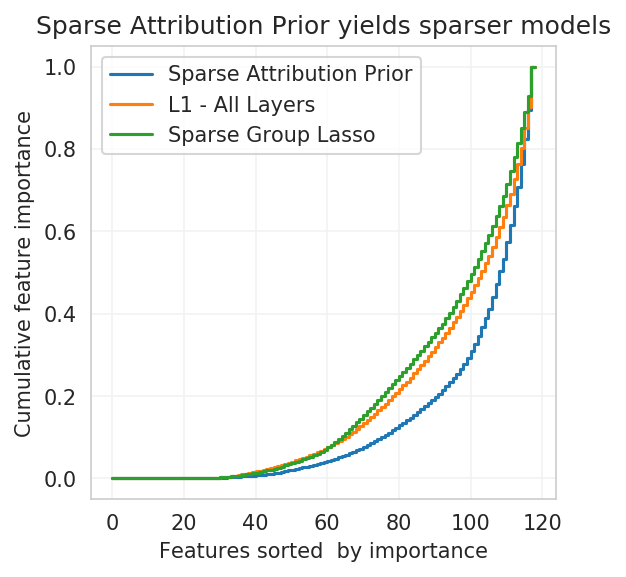

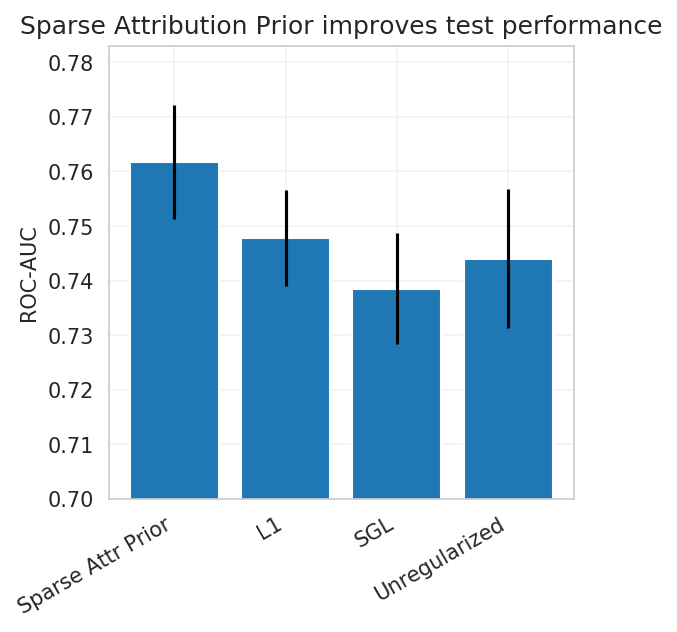

In [10]:
plt.figure(dpi=150,figsize=(4,4))
shap_cdf_plot(eg_results[eg_ind][MSHAP],label='Sparse Attribution Prior')
shap_cdf_plot(l1_results[l1_ind][MSHAP],label='L1 - All Layers')
shap_cdf_plot(sgl_results[sgl_ind][MSHAP],label='Sparse Group Lasso')
plt.ylabel("Cumulative feature importance")
plt.xlabel("Features sorted  by importance")
plt.title("Sparse Attribution Prior yields sparser models")
plt.legend()

plt.figure(dpi=150,figsize=(4,4))
plt.bar(range(4),results.values[0,:],yerr=2*results.values[1,:]/np.sqrt(10))
plt.xticks(range(4),['Sparse Attr Prior', 'L1', 'SGL', 'Unregularized'],rotation=30,ha='right')
plt.ylim(0.7,0.783)
plt.ylabel("ROC-AUC")
plt.title("Sparse Attribution Prior improves test performance")
plt.show();